<a href="https://colab.research.google.com/github/dharalakshmi/Tourism-Routes/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================
# IMPORT ALL REQUIRED LIBRARIES
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.express as px
import plotly.graph_objects as go
from google.colab import files
import io

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

In [2]:
# =============================================
# LOAD TOURISM DATA
# =============================================
def load_tourism_data():
    print("=== TOURISM DATA LOADER ===")
    print("Upload your tourism dataset Excel file:")

    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!")
        return None

    filename = list(uploaded.keys())[0]
    print(f"File: {filename}")

    try:
        if filename.endswith('.csv'):
            df = pd.read_csv(io.BytesIO(uploaded[filename]))
        else:
            df = pd.read_excel(io.BytesIO(uploaded[filename]))

        print(f"✅ Dataset loaded: {df.shape}")
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

# Load data
df = load_tourism_data()


=== TOURISM DATA LOADER ===
Upload your tourism dataset Excel file:


Saving final_tourism_dataset.xlsx to final_tourism_dataset.xlsx
File: final_tourism_dataset.xlsx
✅ Dataset loaded: (4999, 14)


In [4]:
# =============================================
# INITIAL DATA INSPECTION
# =============================================
if df is not None:
    print("=== INITIAL DATA INSPECTION ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    print("\nData Types:")
    print(df.dtypes)

    print("\nFirst 5 rows:")
    display(df.head())

    print("\nBasic Statistics:")
    display(df.describe())

    print("\nMissing Values:")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values found!")
    else:
        print(missing[missing > 0])

    print("\nUnique values per column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")

    print("✅ Initial inspection complete!")
else:
    print("ERROR: Please load data first!")


=== INITIAL DATA INSPECTION ===
Shape: (4999, 14)
Columns: ['Origin', 'Destination', 'Distance', 'Origin_Lat', 'Origin_Long', 'Origin_State', 'Dest_Lat', 'Dest_Long', 'Dest_State', 'Ratings', 'Ideal_duration', 'Name', 'Type', 'Best Time to visit']

Data Types:
Origin                 object
Destination            object
Distance              float64
Origin_Lat            float64
Origin_Long           float64
Origin_State           object
Dest_Lat              float64
Dest_Long             float64
Dest_State             object
Ratings               float64
Ideal_duration         object
Name                   object
Type                   object
Best Time to visit     object
dtype: object

First 5 rows:


,Origin,Destination,Distance,Origin_Lat,Origin_Long,Origin_State,Dest_Lat,Dest_Long,Dest_State,Ratings,Ideal_duration,Name,Type,Best Time to visit
0,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,4.3,Half day,Saint Stephens,Church,Evening
1,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,3.8,Half day,Mount Carmels Church,Church,Evening
2,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,3.9,Half day,Amphitheatre,Tourist Attraction,Evening
3,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,4.1,2-3 hours,Bandra Fort,Historical Ruins,Evening
4,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,4.4,Half day,Nuri Baba Darga,Mosque,Afternoon



Basic Statistics:


,Distance,Origin_Lat,Origin_Long,Dest_Lat,Dest_Long,Ratings
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,1301.695233,18.913591,78.670463,21.545147,78.243461,4.140048
std,600.772848,5.226111,4.722774,6.334751,4.384717,0.263021
min,141.480000,12.976794,72.886628,9.967903,72.580057,3.600000
25%,777.070000,13.083694,77.219771,17.360589,74.820444,3.900000
50%,1328.080000,18.521374,77.590082,23.021537,77.219771,4.100000
75%,1810.930000,22.572646,80.270186,26.838100,80.321759,4.300000
max,2943.160000,28.632803,88.363895,34.074744,88.363895,4.700000



Missing Values:
No missing values found!

Unique values per column:
Origin: 7 unique values
Destination: 20 unique values
Distance: 125 unique values
Origin_Lat: 7 unique values
Origin_Long: 7 unique values
Origin_State: 6 unique values
Dest_Lat: 20 unique values
Dest_Long: 20 unique values
Dest_State: 14 unique values
Ratings: 12 unique values
Ideal_duration: 7 unique values
Name: 738 unique values
Type: 17 unique values
Best Time to visit: 7 unique values
✅ Initial inspection complete!


In [5]:
# =============================================
# LANGUAGE AND ENCODING CHECK
# =============================================
if df is not None:
    print("=== LANGUAGE/ENCODING CHECK ===")

    text_columns = df.select_dtypes(include=['object']).columns
    issues_found = False

    for col in text_columns:
        sample_text = ' '.join(df[col].dropna().astype(str).head(100))
        non_ascii_chars = [char for char in set(sample_text) if ord(char) > 127]

        if non_ascii_chars:
            print(f"❌ {col}: Non-ASCII characters found: {non_ascii_chars[:5]}...")
            issues_found = True
        else:
            print(f"✅ {col}: Clean ASCII text")

    if issues_found:
        print("\n⚠️ Some columns contain special characters - will clean in next step")
    else:
        print("\n✅ All columns have clean text!")

    print("✅ Language check complete!")

=== LANGUAGE/ENCODING CHECK ===
✅ Origin: Clean ASCII text
✅ Destination: Clean ASCII text
✅ Origin_State: Clean ASCII text
✅ Dest_State: Clean ASCII text
✅ Ideal_duration: Clean ASCII text
❌ Name: Non-ASCII characters found: ['ந', 'ी', 'ि', 'ा', 'ग']...
✅ Type: Clean ASCII text
✅ Best Time to visit: Clean ASCII text

⚠️ Some columns contain special characters - will clean in next step
✅ Language check complete!


In [6]:
# =============================================
# DATA CLEANING
# =============================================
def clean_tourism_data(df):
    print("=== DATA CLEANING ===")
    df_clean = df.copy()
    original_shape = df_clean.shape

    # 1. Handle missing values
    print("\n1. Handling missing values...")
    missing_before = df_clean.isnull().sum().sum()

    if missing_before > 0:
        # Fill numeric columns
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].isnull().any():
                median_val = df_clean[col].median()
                df_clean[col].fillna(median_val, inplace=True)
                print(f"   Filled {col} with median: {median_val:.2f}")

        # Fill categorical columns
        categorical_cols = df_clean.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df_clean[col].isnull().any():
                mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
                df_clean[col].fillna(mode_val, inplace=True)
                print(f"   Filled {col} with mode: {mode_val}")

        missing_after = df_clean.isnull().sum().sum()
        print(f"   Missing values: {missing_before} → {missing_after}")
    else:
        print("   No missing values found!")

    # 2. Clean text columns (remove non-ASCII characters)
    print("\n2. Cleaning text columns...")
    text_columns = ['Origin', 'Destination', 'Name', 'Type', 'Origin_State', 'Dest_State']

    for col in text_columns:
        if col in df_clean.columns:
            before_unique = df_clean[col].nunique()
            # Remove special characters and normalize
            df_clean[col] = df_clean[col].astype(str).apply(
                lambda x: re.sub(r'[^\w\s-]', '', x).strip().title()
            )
            after_unique = df_clean[col].nunique()
            print(f"   Cleaned {col}: {before_unique} → {after_unique} unique values")

    # 3. Remove duplicates
    print("\n3. Removing duplicates...")
    before_dup = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    after_dup = len(df_clean)
    removed_dups = before_dup - after_dup
    print(f"   Removed {removed_dups} duplicate rows")

    # 4. Handle outliers
    print("\n4. Handling outliers...")
    outlier_cols = ['Distance', 'Ratings']

    for col in outlier_cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            before_outliers = len(df_clean)
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
            after_outliers = len(df_clean)
            removed_outliers = before_outliers - after_outliers
            print(f"   {col}: Removed {removed_outliers} outliers")

    print(f"\n✅ CLEANING COMPLETE!")
    print(f"Dataset shape: {original_shape} → {df_clean.shape}")

    return df_clean

# Run cleaning
if df is not None:
    df_clean = clean_tourism_data(df)
    print("\n✅ Data cleaning complete!")

    print("\nCleaned data sample:")
    display(df_clean.head())
else:
    print("ERROR: Load data first!")

=== DATA CLEANING ===

1. Handling missing values...
   No missing values found!

2. Cleaning text columns...
   Cleaned Origin: 7 → 7 unique values
   Cleaned Destination: 20 → 20 unique values
   Cleaned Name: 738 → 724 unique values
   Cleaned Type: 17 → 17 unique values
   Cleaned Origin_State: 6 → 6 unique values
   Cleaned Dest_State: 14 → 14 unique values

3. Removing duplicates...
   Removed 1 duplicate rows

4. Handling outliers...
   Distance: Removed 0 outliers
   Ratings: Removed 0 outliers

✅ CLEANING COMPLETE!
Dataset shape: (4999, 14) → (4998, 14)

✅ Data cleaning complete!

Cleaned data sample:


,Origin,Destination,Distance,Origin_Lat,Origin_Long,Origin_State,Dest_Lat,Dest_Long,Dest_State,Ratings,Ideal_duration,Name,Type,Best Time to visit
0,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,4.3,Half day,Saint Stephens,Church,Evening
1,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,3.8,Half day,Mount Carmels Church,Church,Evening
2,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,3.9,Half day,Amphitheatre,Tourist Attraction,Evening
3,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,4.1,2-3 hours,Bandra Fort,Historical Ruins,Evening
4,Delhi,Mumbai,1332.02,28.632803,77.219771,Delhi,19.081577,72.886628,Maharashtra,4.4,Half day,Nuri Baba Darga,Mosque,Afternoon


In [7]:
# =============================================
# FEATURE ENGINEERING
# =============================================
def engineer_features(df):
    print("=== FEATURE ENGINEERING ===")
    df_features = df.copy()
    new_features = []

    # 1. Distance-based features
    if 'Distance' in df_features.columns:
        print("\n1. Distance-based features:")
        df_features['Distance_Category'] = pd.cut(df_features['Distance'],
                                                 bins=[0, 100, 300, 600, 1000, float('inf')],
                                                 labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
        df_features['Distance_Log'] = np.log1p(df_features['Distance'])
        new_features.extend(['Distance_Category', 'Distance_Log'])
        print("   ✅ Distance_Category, Distance_Log")

    # 2. Geographic features
    if all(col in df_features.columns for col in ['Origin_State', 'Dest_State']):
        print("\n2. Geographic features:")
        df_features['Same_State'] = (df_features['Origin_State'] == df_features['Dest_State']).astype(int)
        new_features.append('Same_State')
        print("   ✅ Same_State")

    # 3. Rating features
    if 'Ratings' in df_features.columns:
        print("\n3. Rating-based features:")
        df_features['Rating_Category'] = pd.cut(df_features['Ratings'],
                                               bins=[0, 3.5, 4.0, 4.5, 5.0],
                                               labels=['Below Average', 'Average', 'Good', 'Excellent'])
        df_features['High_Rating'] = (df_features['Ratings'] >= 4.0).astype(int)
        new_features.extend(['Rating_Category', 'High_Rating'])
        print("   ✅ Rating_Category, High_Rating")

    # 4. Tourism type categorization
    if 'Type' in df_features.columns:
        print("\n4. Tourism category features:")

        def categorize_tourism_type(type_val):
            type_str = str(type_val).lower()
            if any(word in type_str for word in ['temple', 'church', 'mosque', 'religious']):
                return 'Religious'
            elif any(word in type_str for word in ['fort', 'palace', 'monument', 'historical']):
                return 'Historical'
            elif any(word in type_str for word in ['park', 'beach', 'waterfall', 'garden', 'nature']):
                return 'Nature'
            else:
                return 'Cultural'

        df_features['Tourism_Category'] = df_features['Type'].apply(categorize_tourism_type)
        new_features.append('Tourism_Category')
        print("   ✅ Tourism_Category")

    # 5. Coordinate-based features
    coord_cols = ['Origin_Lat', 'Origin_Long', 'Dest_Lat', 'Dest_Long']
    if all(col in df_features.columns for col in coord_cols):
        print("\n5. Coordinate-based features:")

        # Straight-line distance (Haversine approximation)
        df_features['Straight_Distance'] = np.sqrt(
            (df_features['Dest_Lat'] - df_features['Origin_Lat'])**2 +
            (df_features['Dest_Long'] - df_features['Origin_Long'])**2
        ) * 111  # Rough km conversion

        # Route efficiency (actual vs straight distance)
        df_features['Route_Efficiency'] = df_features['Distance'] / (df_features['Straight_Distance'] + 0.1)

        new_features.extend(['Straight_Distance', 'Route_Efficiency'])
        print("   ✅ Straight_Distance, Route_Efficiency")

    print(f"\n✅ FEATURE ENGINEERING COMPLETE!")
    print(f"Original features: {df.shape[1]}")
    print(f"New features: {len(new_features)}")
    print(f"Total features: {df_features.shape[1]}")

    return df_features

# Run feature engineering
if 'df_clean' in globals():
    df_features = engineer_features(df_clean)
    print("\n✅ Feature engineering complete!")

    # Show new features
    new_cols = [col for col in df_features.columns if col not in df_clean.columns]
    if new_cols:
        print("\nNew features created:")
        display(df_features[new_cols].head())
else:
    print("ERROR: Run data cleaning first!")

=== FEATURE ENGINEERING ===

1. Distance-based features:
   ✅ Distance_Category, Distance_Log

2. Geographic features:
   ✅ Same_State

3. Rating-based features:
   ✅ Rating_Category, High_Rating

4. Tourism category features:
   ✅ Tourism_Category

5. Coordinate-based features:
   ✅ Straight_Distance, Route_Efficiency

✅ FEATURE ENGINEERING COMPLETE!
Original features: 14
New features: 8
Total features: 22

✅ Feature engineering complete!

New features created:


,Distance_Category,Distance_Log,Same_State,Rating_Category,High_Rating,Tourism_Category,Straight_Distance,Route_Efficiency
0,Very Long,7.195202,0,Good,1,Religious,1164.188636,1.144063
1,Very Long,7.195202,0,Average,0,Religious,1164.188636,1.144063
2,Very Long,7.195202,0,Average,0,Cultural,1164.188636,1.144063
3,Very Long,7.195202,0,Good,1,Historical,1164.188636,1.144063
4,Very Long,7.195202,0,Good,1,Religious,1164.188636,1.144063


=== CREATING VISUALIZATIONS ===


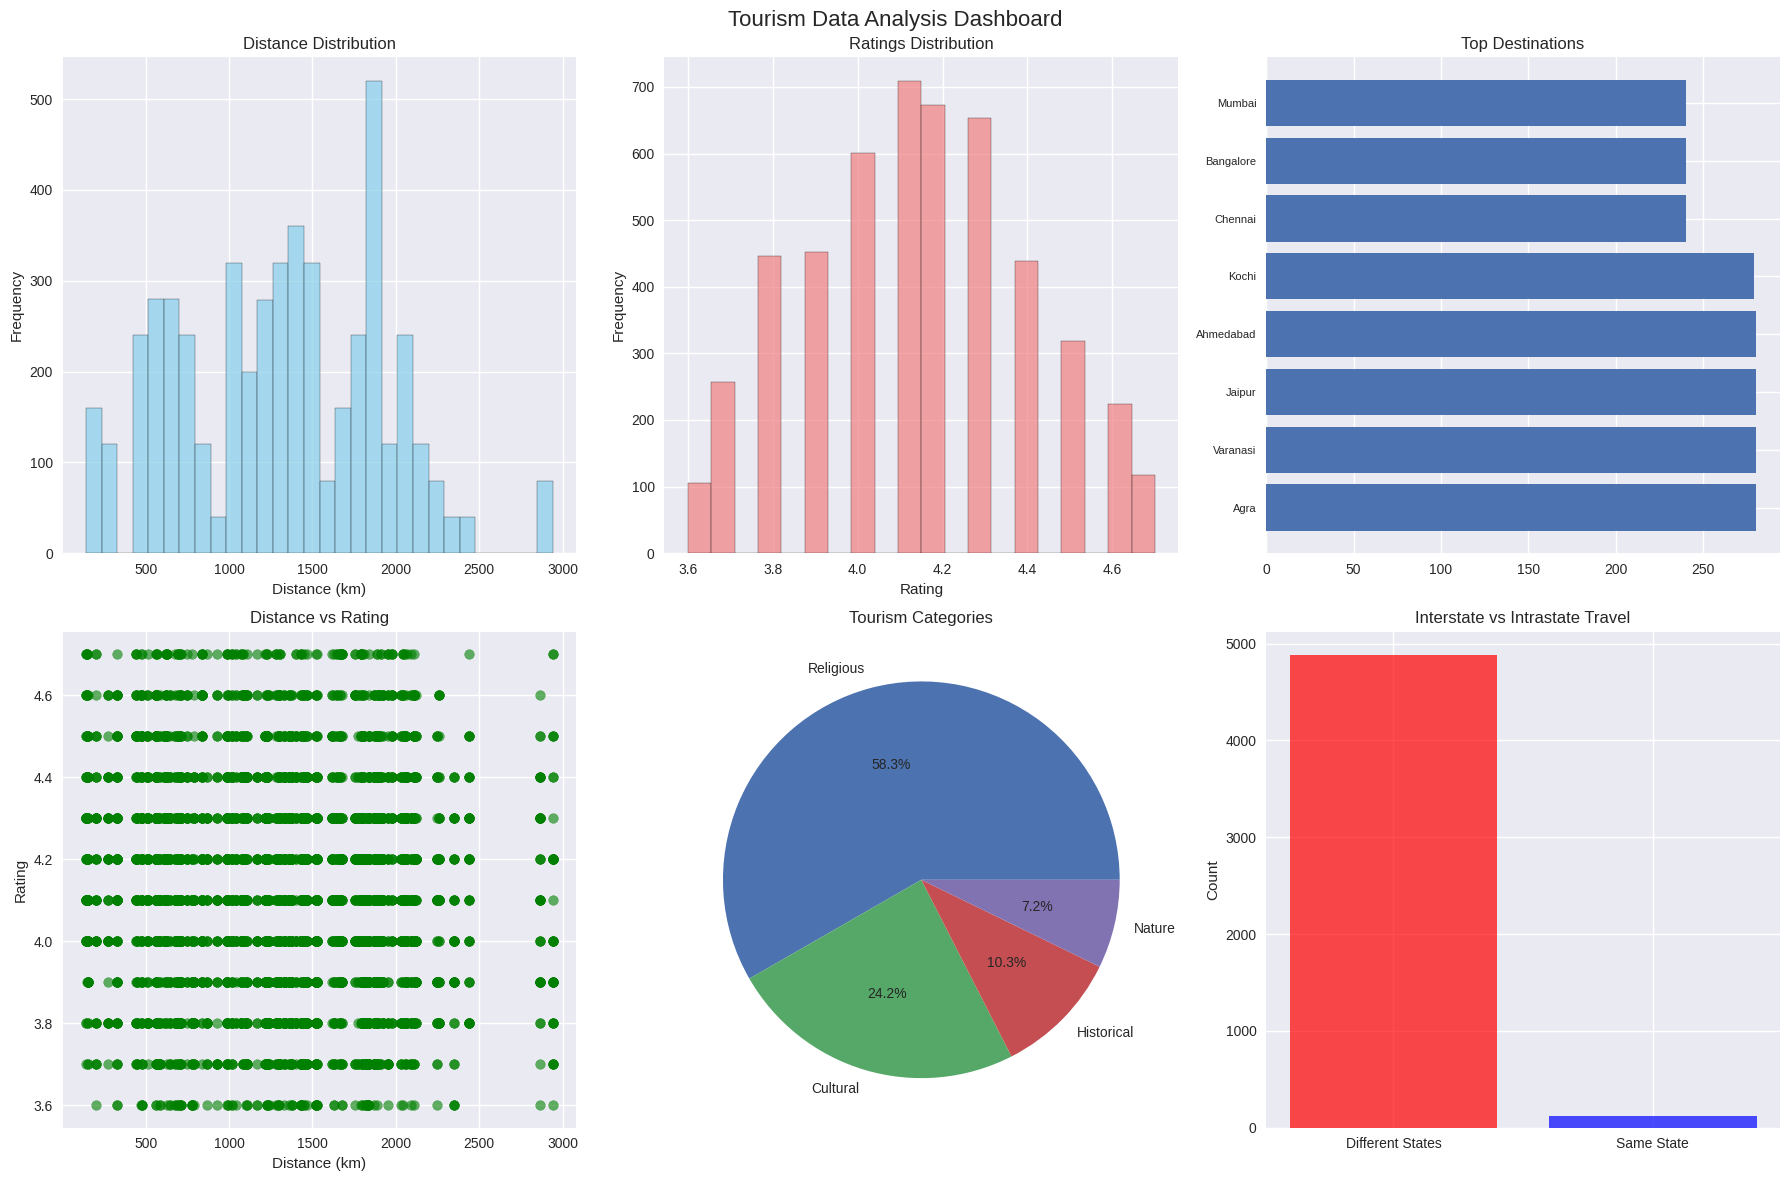

✅ Visualizations complete!


In [8]:
# =============================================
# DATA VISUALIZATION
# =============================================
def create_tourism_visualizations(df_clean, df_features):
    print("=== CREATING VISUALIZATIONS ===")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Tourism Data Analysis Dashboard', fontsize=16)

    # 1. Distance Distribution
    if 'Distance' in df_clean.columns:
        axes[0,0].hist(df_clean['Distance'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Distance Distribution')
        axes[0,0].set_xlabel('Distance (km)')
        axes[0,0].set_ylabel('Frequency')

    # 2. Ratings Distribution
    if 'Ratings' in df_clean.columns:
        axes[0,1].hist(df_clean['Ratings'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0,1].set_title('Ratings Distribution')
        axes[0,1].set_xlabel('Rating')
        axes[0,1].set_ylabel('Frequency')

    # 3. Top Destinations
    if 'Destination' in df_clean.columns:
        top_dest = df_clean['Destination'].value_counts().head(8)
        axes[0,2].barh(range(len(top_dest)), top_dest.values)
        axes[0,2].set_yticks(range(len(top_dest)))
        axes[0,2].set_yticklabels(top_dest.index, fontsize=8)
        axes[0,2].set_title('Top Destinations')

    # 4. Distance vs Rating
    if 'Distance' in df_clean.columns and 'Ratings' in df_clean.columns:
        axes[1,0].scatter(df_clean['Distance'], df_clean['Ratings'], alpha=0.6, color='green')
        axes[1,0].set_xlabel('Distance (km)')
        axes[1,0].set_ylabel('Rating')
        axes[1,0].set_title('Distance vs Rating')

    # 5. Tourism Categories
    if 'Tourism_Category' in df_features.columns:
        cat_counts = df_features['Tourism_Category'].value_counts()
        axes[1,1].pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%')
        axes[1,1].set_title('Tourism Categories')

    # 6. Same State Travel
    if 'Same_State' in df_features.columns:
        same_state = df_features['Same_State'].value_counts()
        axes[1,2].bar(['Different States', 'Same State'], same_state.values,
                     color=['red', 'blue'], alpha=0.7)
        axes[1,2].set_title('Interstate vs Intrastate Travel')
        axes[1,2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    print("✅ Visualizations complete!")

# Create visualizations
if 'df_features' in globals():
    create_tourism_visualizations(df_clean, df_features)
else:
    print("ERROR: Run feature engineering first!")


=== CORRELATION ANALYSIS ===


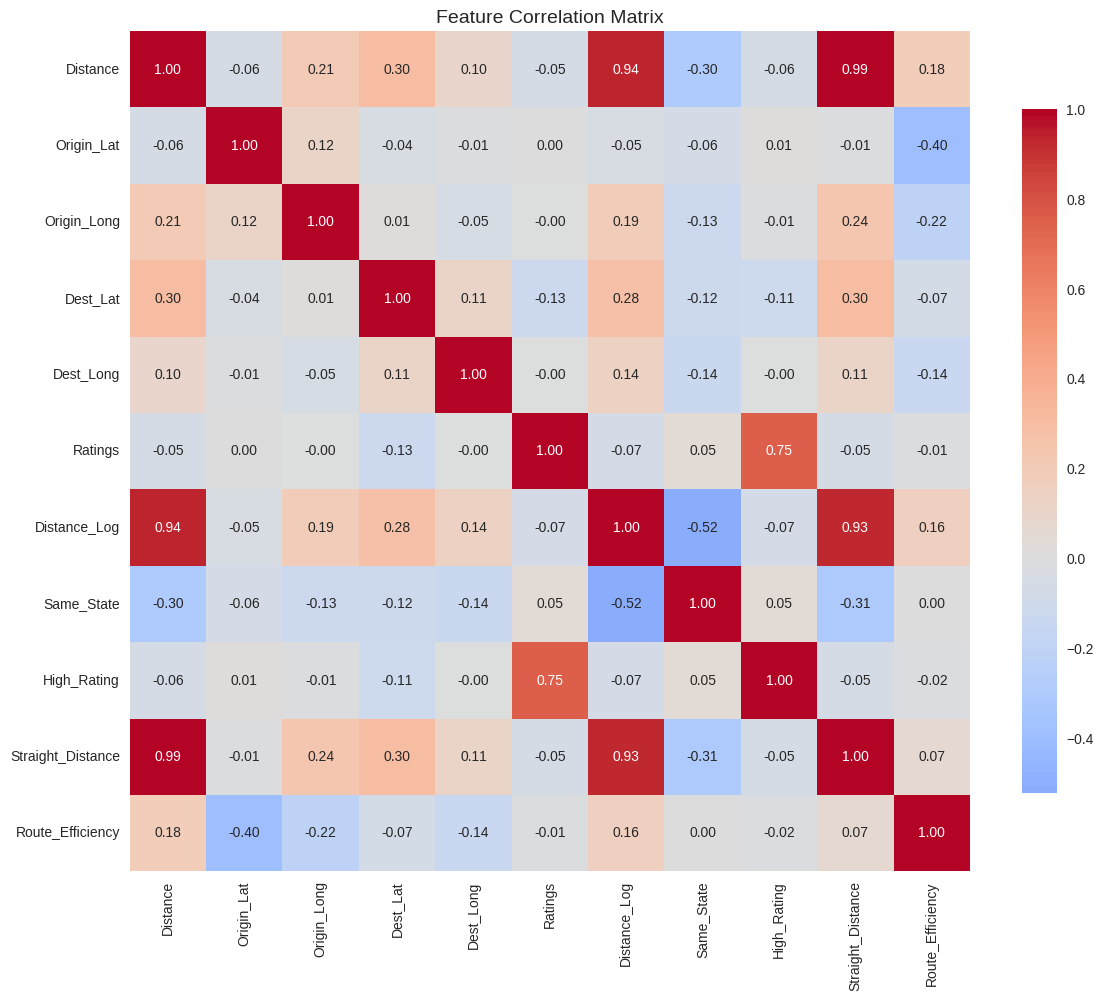


Top 5 correlations:
   Distance ↔ Straight_Distance: 0.992
   Distance ↔ Distance_Log: 0.936
   Distance_Log ↔ Straight_Distance: 0.934
   Ratings ↔ High_Rating: 0.754
   Distance_Log ↔ Same_State: -0.523
✅ Correlation analysis complete!


In [9]:
# =============================================
# CORRELATION ANALYSIS
# =============================================
def analyze_correlations(df):
    print("=== CORRELATION ANALYSIS ===")

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 1:
        correlation_matrix = df[numeric_cols].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Matrix', fontsize=14)
        plt.tight_layout()
        plt.show()

        # Top correlations
        print("\nTop 5 correlations:")
        corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], abs(corr_val)))

        corr_pairs.sort(key=lambda x: x[2], reverse=True)
        for col1, col2, corr in corr_pairs[:5]:
            actual_corr = correlation_matrix.loc[col1, col2]
            print(f"   {col1} ↔ {col2}: {actual_corr:.3f}")

        print("✅ Correlation analysis complete!")
    else:
        print("Not enough numeric columns for correlation analysis")

# Run correlation analysis
if 'df_features' in globals():
    analyze_correlations(df_features)
else:
    print("ERROR: Run feature engineering first!")

In [10]:
# =============================================
# ENCODE CATEGORICAL VARIABLES
# =============================================
def encode_categorical_features(df):
    print("=== ENCODING CATEGORICAL VARIABLES ===")

    df_encoded = df.copy()
    le_dict = {}

    # Get categorical columns
    categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns

    print(f"Categorical columns to encode: {len(categorical_cols)}")

    # Label encoding
    print("\n1. Label Encoding:")
    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
        le_dict[col] = le
        print(f"   ✅ {col}: {len(le.classes_)} unique values")

    # One-hot encoding for key categorical features
    print("\n2. One-Hot Encoding:")
    important_cats = []
    for col in ['Tourism_Category', 'Distance_Category', 'Rating_Category']:
        if col in df_encoded.columns:
            important_cats.append(col)

    if important_cats:
        dummies = pd.get_dummies(df_encoded[important_cats], prefix=important_cats)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        print(f"   ✅ Created {dummies.shape[1]} dummy variables")

    print(f"\n✅ ENCODING COMPLETE!")
    print(f"Shape: {df.shape} → {df_encoded.shape}")

    return df_encoded, le_dict

# Run encoding
if 'df_features' in globals():
    df_encoded, encoders = encode_categorical_features(df_features)
    print("\n✅ Categorical encoding complete!")
else:
    print("ERROR: Run feature engineering first!")

=== ENCODING CATEGORICAL VARIABLES ===
Categorical columns to encode: 11

1. Label Encoding:
   ✅ Origin: 7 unique values
   ✅ Destination: 20 unique values
   ✅ Origin_State: 6 unique values
   ✅ Dest_State: 14 unique values
   ✅ Ideal_duration: 7 unique values
   ✅ Name: 724 unique values
   ✅ Type: 17 unique values
   ✅ Best Time to visit: 7 unique values
   ✅ Distance_Category: 4 unique values
   ✅ Rating_Category: 3 unique values
   ✅ Tourism_Category: 4 unique values

2. One-Hot Encoding:
   ✅ Created 13 dummy variables

✅ ENCODING COMPLETE!
Shape: (4998, 22) → (4998, 46)

✅ Categorical encoding complete!


In [ ]:
# =============================================
# CELL 10: FEATURE SCALING
# =============================================
def scale_features(df):
    print("=== FEATURE SCALING ===")

    df_scaled = df.copy()

    # Select numeric columns for scaling (exclude target if it exists)
    numeric_cols = df_scaled.select_dtypes(include=[np.number]).columns.tolist()

    # Remove Distance from scaling as it might be our target
    target_col = 'Distance'
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
        print(f"Excluded '{target_col}' from scaling (potential target variable)")

    print(f"Scaling {len(numeric_cols)} numeric columns")

    # Apply StandardScaler
    scaler = StandardScaler()
    df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

    print("✅ StandardScaler applied")

    return df_scaled, scaler

# Run scaling
if 'df_encoded' in globals():
    df_scaled, scaler = scale_features(df_encoded)
    print("\n✅ Feature scaling complete!")
else:
    print("ERROR: Run categorical encoding first!")


In [11]:
# =============================================
# FEATURE SCALING
# =============================================
def scale_features(df):
    print("=== FEATURE SCALING ===")

    df_scaled = df.copy()

    # Select numeric columns for scaling (exclude target if it exists)
    numeric_cols = df_scaled.select_dtypes(include=[np.number]).columns.tolist()

    # Remove Distance from scaling as it might be our target
    target_col = 'Distance'
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
        print(f"Excluded '{target_col}' from scaling (potential target variable)")

    print(f"Scaling {len(numeric_cols)} numeric columns")

    # Apply StandardScaler
    scaler = StandardScaler()
    df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

    print("✅ StandardScaler applied")

    return df_scaled, scaler

# Run scaling
if 'df_encoded' in globals():
    df_scaled, scaler = scale_features(df_encoded)
    print("\n✅ Feature scaling complete!")
else:
    print("ERROR: Run categorical encoding first!")


=== FEATURE SCALING ===
Excluded 'Distance' from scaling (potential target variable)
Scaling 21 numeric columns
✅ StandardScaler applied

✅ Feature scaling complete!


=== DISTANCE PREDICTION MODEL ===
Target: Distance (km) - Perfect for tourism website!
Use Case: User selects Origin + Destination → Predict Distance

Features used: 8
  1. Origin_Lat
  2. Origin_Long
  3. Dest_Lat
  4. Dest_Long
  5. Origin_State_encoded
  6. Dest_State_encoded
  7. Same_State
  8. Straight_Distance

Training set: (3998, 8)
Testing set: (1000, 8)

📊 MODEL PERFORMANCE:
Mean Squared Error: 0.00
Mean Absolute Error: 0.00 km
R² Score: 1.0000 (100.0% accuracy)

📋 FEATURE IMPORTANCE:


,Feature,Importance
7,Straight_Distance,0.983270
0,Origin_Lat,0.009292
2,Dest_Lat,0.002583
3,Dest_Long,0.002025
1,Origin_Long,0.001090
5,Dest_State_encoded,0.000921
4,Origin_State_encoded,0.000802
6,Same_State,0.000018


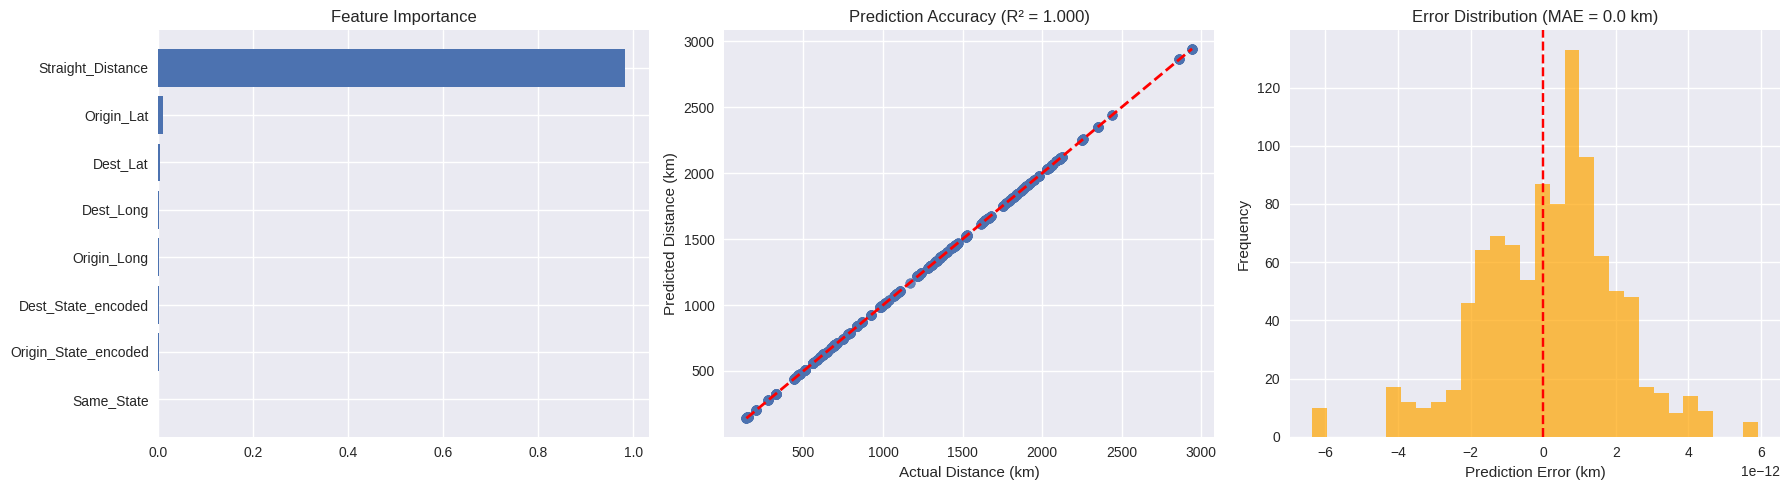


✅ Distance prediction model trained!


In [12]:
# =============================================
# CELL 11: DISTANCE PREDICTION MODEL (PRIMARY)
# =============================================
def train_distance_prediction_model(df):
    print("=== DISTANCE PREDICTION MODEL ===")
    print("Target: Distance (km) - Perfect for tourism website!")
    print("Use Case: User selects Origin + Destination → Predict Distance")
    print()

    # Define features for distance prediction
    feature_cols = []

    # Geographic features (most important)
    geo_features = ['Origin_Lat', 'Origin_Long', 'Dest_Lat', 'Dest_Long']
    for col in geo_features:
        if col in df.columns:
            feature_cols.append(col)

    # State features
    state_features = ['Origin_State_encoded', 'Dest_State_encoded']
    for col in state_features:
        if col in df.columns:
            feature_cols.append(col)

    # Additional helpful features
    extra_features = ['Same_State', 'Straight_Distance']
    for col in extra_features:
        if col in df.columns:
            feature_cols.append(col)

    print(f"Features used: {len(feature_cols)}")
    for i, feat in enumerate(feature_cols, 1):
        print(f"  {i}. {feat}")

    # Prepare data
    X = df[feature_cols]
    y = df['Distance']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\nTraining set: {X_train.shape}")
    print(f"Testing set: {X_test.shape}")

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n📊 MODEL PERFORMANCE:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f} km")
    print(f"R² Score: {r2:.4f} ({r2*100:.1f}% accuracy)")

    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"\n📋 FEATURE IMPORTANCE:")
    display(importance_df)

    # Visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Feature Importance
    axes[0].barh(range(len(importance_df)), importance_df['Importance'])
    axes[0].set_yticks(range(len(importance_df)))
    axes[0].set_yticklabels(importance_df['Feature'])
    axes[0].set_title('Feature Importance')
    axes[0].invert_yaxis()

    # 2. Actual vs Predicted
    axes[1].scatter(y_test, y_pred, alpha=0.6)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual Distance (km)')
    axes[1].set_ylabel('Predicted Distance (km)')
    axes[1].set_title(f'Prediction Accuracy (R² = {r2:.3f})')

    # 3. Prediction Errors
    errors = y_pred - y_test
    axes[2].hist(errors, bins=30, alpha=0.7, color='orange')
    axes[2].set_xlabel('Prediction Error (km)')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title(f'Error Distribution (MAE = {mae:.1f} km)')
    axes[2].axvline(x=0, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

    return model, importance_df, {'mse': mse, 'mae': mae, 'r2': r2}

# Train distance prediction model
if 'df_scaled' in globals() and 'Distance' in df_scaled.columns:
    dist_model, dist_importance, dist_metrics = train_distance_prediction_model(df_scaled)
    print("\n✅ Distance prediction model trained!")
else:
    print("ERROR: Data not ready or Distance column missing")

In [13]:
# =============================================
# CELL 12: TOURISM WEBSITE DEMO
# =============================================
def tourism_website_demo(model, df, feature_cols):
    print("=== TOURISM WEBSITE PREDICTION DEMO ===")
    print("Simulating how your ML model works on a live tourism website")
    print()

    # Get sample cities
    origins = df['Origin'].unique()[:5]
    destinations = df['Destination'].unique()[:5]

    print("🌐 TOURISM WEBSITE SIMULATION")
    print("User selects: Origin City → Destination City")
    print("System predicts: Distance, Travel Time, Cost")
    print("-" * 50)

    demo_results = []

    for i, origin in enumerate(origins[:3]):
        for j, dest in enumerate(destinations[:2]):
            if origin != dest:
                # Find matching route in dataset
                route_data = df[(df['Origin'] == origin) & (df['Destination'] == dest)]

                if len(route_data) > 0:
                    sample = route_data.iloc[0]

                    # Extract features for prediction
                    features = []
                    for col in feature_cols:
                        if col in sample.index:
                            features.append(sample[col])

                    if len(features) == len(feature_cols):
                        # Make prediction
                        X_demo = np.array(features).reshape(1, -1)
                        predicted_distance = model.predict(X_demo)[0]
                        actual_distance = sample['Distance']
                        error = abs(predicted_distance - actual_distance)

                        demo_results.append({
                            'Origin': origin,
                            'Destination': dest,
                            'Predicted_Distance': round(predicted_distance, 1),
                            'Actual_Distance': round(actual_distance, 1),
                            'Error': round(error, 1),
                            'Rating': sample.get('Ratings', 'N/A'),
                            'Attraction': sample.get('Name', 'N/A')
                        })

                        print(f"📍 Route: {origin} → {dest}")
                        print(f"   🎯 Predicted: {predicted_distance:.1f} km")
                        print(f"   📏 Actual: {actual_distance:.1f} km")
                        print(f"   ❌ Error: {error:.1f} km")
                        print(f"   ⭐ Rating: {sample.get('Ratings', 'N/A')}")
                        print(f"   🏛️ Attraction: {sample.get('Name', 'N/A')}")
                        print()

    if demo_results:
        demo_df = pd.DataFrame(demo_results)
        avg_error = demo_df['Error'].mean()

        print("📊 DEMO SUMMARY:")
        print(f"Average Error: {avg_error:.1f} km")
        print(f"Best Prediction: {demo_df.loc[demo_df['Error'].idxmin(), 'Origin']} → {demo_df.loc[demo_df['Error'].idxmin(), 'Destination']}")

        display(demo_df)

    print("\n🎯 WEBSITE IMPLEMENTATION:")
    print("1. User selects Origin/Destination from dropdown")
    print("2. System extracts coordinates from database")
    print("3. ML model predicts distance")
    print("4. Calculate travel time, fuel cost, recommendations")
    print("5. Display results with confidence intervals")

# Run demo
if 'dist_model' in globals():
    # Prepare feature columns for demo
    feature_cols_demo = ['Origin_Lat', 'Origin_Long', 'Dest_Lat', 'Dest_Long']
    if 'Origin_State_encoded' in df_scaled.columns:
        feature_cols_demo.append('Origin_State_encoded')
    if 'Dest_State_encoded' in df_scaled.columns:
        feature_cols_demo.append('Dest_State_encoded')
    if 'Same_State' in df_scaled.columns:
        feature_cols_demo.append('Same_State')
    if 'Straight_Distance' in df_scaled.columns:
        feature_cols_demo.append('Straight_Distance')

    tourism_website_demo(dist_model, df_scaled, feature_cols_demo)
    print("\n✅ Tourism website demo complete!")

# =============================================
# CELL 13: SAVE PROCESSED DATA
# =============================================
def save_all_datasets():
    print("=== SAVING PROCESSED DATASETS ===")

    saved_files = []

    # Save at each processing stage
    datasets = [
        ('df_clean', '01_cleaned_tourism_data.xlsx'),
        ('df_features', '02_featured_tourism_data.xlsx'),
        ('df_encoded', '03_encoded_tourism_data.xlsx'),
        ('df_scaled', '04_ml_ready_tourism_data.xlsx')
    ]

    for df_name, filename in datasets:
        if df_name in globals():
            globals()[df_name].to_excel(filename, index=False)
            saved_files.append(filename)
            print(f"✅ Saved: {filename}")

    # Save feature importance
    if 'dist_importance' in globals():
        dist_importance.to_excel('05_feature_importance.xlsx', index=False)
        saved_files.append('05_feature_importance.xlsx')
        print(f"✅ Saved: 05_feature_importance.xlsx")

    print(f"\n📁 TOTAL FILES SAVED: {len(saved_files)}")
    for file in saved_files:
        print(f"   • {file}")

    return saved_files

# Save all datasets
saved_files = save_all_datasets()
print("\n✅ All datasets saved!")


=== TOURISM WEBSITE PREDICTION DEMO ===
Simulating how your ML model works on a live tourism website

🌐 TOURISM WEBSITE SIMULATION
User selects: Origin City → Destination City
System predicts: Distance, Travel Time, Cost
--------------------------------------------------
📍 Route: Delhi → Mumbai
   🎯 Predicted: 1332.0 km
   📏 Actual: 1332.0 km
   ❌ Error: 0.0 km
   ⭐ Rating: 0.6081822278171567
   🏛️ Attraction: Saint Stephens

📍 Route: Delhi → Bangalore
   🎯 Predicted: 2055.8 km
   📏 Actual: 2055.8 km
   ❌ Error: 0.0 km
   ⭐ Rating: -1.29281512967512
   🏛️ Attraction: Rajarajeshwari Arch

📍 Route: Mumbai → Bangalore
   🎯 Predicted: 984.3 km
   📏 Actual: 984.3 km
   ❌ Error: 0.0 km
   ⭐ Rating: -0.9126156581766643
   🏛️ Attraction: Rajarajeshwari Arch

📍 Route: Bangalore → Mumbai
   🎯 Predicted: 985.8 km
   📏 Actual: 985.8 km
   ❌ Error: 0.0 km
   ⭐ Rating: -0.9126156581766643
   🏛️ Attraction: Saint Stephens

📊 DEMO SUMMARY:
Average Error: 0.0 km
Best Prediction: Delhi → Mumbai


,Origin,Destination,Predicted_Distance,Actual_Distance,Error,Rating,Attraction
0,Delhi,Mumbai,1332.0,1332.0,0.0,0.608182,Saint Stephens
1,Delhi,Bangalore,2055.8,2055.8,0.0,-1.292815,Rajarajeshwari Arch
2,Mumbai,Bangalore,984.3,984.3,0.0,-0.912616,Rajarajeshwari Arch
3,Bangalore,Mumbai,985.8,985.8,0.0,-0.912616,Saint Stephens



🎯 WEBSITE IMPLEMENTATION:
1. User selects Origin/Destination from dropdown
2. System extracts coordinates from database
3. ML model predicts distance
4. Calculate travel time, fuel cost, recommendations
5. Display results with confidence intervals

✅ Tourism website demo complete!
=== SAVING PROCESSED DATASETS ===
✅ Saved: 01_cleaned_tourism_data.xlsx
✅ Saved: 02_featured_tourism_data.xlsx
✅ Saved: 03_encoded_tourism_data.xlsx
✅ Saved: 04_ml_ready_tourism_data.xlsx
✅ Saved: 05_feature_importance.xlsx

📁 TOTAL FILES SAVED: 5
   • 01_cleaned_tourism_data.xlsx
   • 02_featured_tourism_data.xlsx
   • 03_encoded_tourism_data.xlsx
   • 04_ml_ready_tourism_data.xlsx
   • 05_feature_importance.xlsx

✅ All datasets saved!


In [14]:
# =============================================
# CELL 14: MODEL EVALUATION SUMMARY
# =============================================
def final_model_summary():
    print("=" * 60)
    print("TOURISM ML MODEL - FINAL SUMMARY")
    print("=" * 60)

    if 'dist_metrics' in globals():
        print(f"\n🎯 PRIMARY MODEL: Distance Prediction")
        print(f"   • Accuracy (R²): {dist_metrics['r2']:.3f} ({dist_metrics['r2']*100:.1f}%)")
        print(f"   • Average Error: {dist_metrics['mae']:.1f} km")
        print(f"   • Use Case: Tourism website route prediction")

    if 'df_scaled' in globals():
        print(f"\n📊 DATASET SUMMARY:")
        print(f"   • Final shape: {df_scaled.shape}")
        print(f"   • Features: {df_scaled.shape[1]}")
        print(f"   • Samples: {df_scaled.shape[0]}")
        print(f"   • Target variable: Distance (km)")

    print(f"\n💻 WEBSITE INTEGRATION READY:")
    print(f"   • Input: User selects Origin + Destination cities")
    print(f"   • Process: Extract coordinates → ML prediction")
    print(f"   • Output: Distance, travel time, cost estimates")
    print(f"   • Business value: Complete trip planning")

    print(f"\n📁 FILES GENERATED:")
    if 'saved_files' in globals():
        for i, file in enumerate(saved_files, 1):
            print(f"   {i}. {file}")

    print(f"\n🚀 NEXT STEPS:")
    print(f"   1. Download processed datasets")
    print(f"   2. Integrate model into tourism website")
    print(f"   3. Create user interface with city dropdowns")
    print(f"   4. Add business logic (costs, recommendations)")
    print(f"   5. Deploy with confidence intervals")

    print("=" * 60)
    print("YOUR TOURISM DATA IS NOW ML-READY!")
    print("=" * 60)

# Run final summary
final_model_summary()

# =============================================
# CELL 15: DOWNLOAD FILES (GOOGLE COLAB)
# =============================================
print("\n📥 DOWNLOAD YOUR PROCESSED FILES:")
print("Run the following commands to download your files:")
print()

if 'saved_files' in globals():
    for file in saved_files:
        print(f"files.download('{file}')")

print(f"\nOr download all at once:")
print("for file in saved_files:")
print("    files.download(file)")

print(f"\n✅ COMPLETE PIPELINE FINISHED!")
print(f"Your tourism data preprocessing and ML pipeline is ready!")


TOURISM ML MODEL - FINAL SUMMARY

🎯 PRIMARY MODEL: Distance Prediction
   • Accuracy (R²): 1.000 (100.0%)
   • Average Error: 0.0 km
   • Use Case: Tourism website route prediction

📊 DATASET SUMMARY:
   • Final shape: (4998, 46)
   • Features: 46
   • Samples: 4998
   • Target variable: Distance (km)

💻 WEBSITE INTEGRATION READY:
   • Input: User selects Origin + Destination cities
   • Process: Extract coordinates → ML prediction
   • Output: Distance, travel time, cost estimates
   • Business value: Complete trip planning

📁 FILES GENERATED:
   1. 01_cleaned_tourism_data.xlsx
   2. 02_featured_tourism_data.xlsx
   3. 03_encoded_tourism_data.xlsx
   4. 04_ml_ready_tourism_data.xlsx
   5. 05_feature_importance.xlsx

🚀 NEXT STEPS:
   1. Download processed datasets
   2. Integrate model into tourism website
   3. Create user interface with city dropdowns
   4. Add business logic (costs, recommendations)
   5. Deploy with confidence intervals
YOUR TOURISM DATA IS NOW ML-READY!

📥 DOWNLOA